# Draft of EKF implementation for temporal alignment

Using CTRA model.

Heavily based on [balzer82 implementation](https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb) and [giovannix adaptation](https://github.com/giovannix/kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb).

In [1]:
from sympy import symbols, Matrix, init_printing
from IPython.display import display

init_printing()

vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('v \psi \dot\psi T x y lat lon a')

hs = Matrix([[xs],
             [ys],
             [psis],
             [vs],
             [dpsis],
             [axs]])

state = Matrix([xs,ys,psis,vs,dpsis,axs])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]

In [2]:
def log_state_and_noises(iteration, state, predicted_state, noises):
    updated_state_s, noise_s, sensors_std_s, = symbols('updated\_state noise sensors\_std')
    
    p_x, p_y, p_psi, p_v, p_dotpsi, p_a = symbols('\hat\ x \hat\ y \hat\ \psi \hat\ v \hat{\dot{\psi}} \hat\ a')
    predicted_state_matrix_s = Matrix([p_x, p_y, p_psi, p_v, p_dotpsi, p_a])
    predicted_state_s = symbols('predicted\_state')
    
    print(f'Iteration {iteration}:')
    print('='*100)
        
    display(Eq(
        predicted_state_s,
        Eq(
            predicted_state_matrix_s,
            Matrix(predicted_state),
            evaluate=False
        )
    ))
    
    print('-'*100)
    display(Eq(
        updated_state_s,
        Eq(state, Matrix(x), evaluate=False)
    ))
    
    print('*Noise included')  
    print('-'*100)
    
    display(Eq(
        Le(
            -sensors_std_s,
            Le(noise_s, sensors_std_s),
            evaluate=False
        ),
        Le(
            Matrix(-sensors_std),
            Le(Matrix(noises), Matrix(sensors_std), evaluate=False),
            evaluate=False
        )
    ))

    print('='*100)

In [3]:
import numpy as np
from numpy.random import default_rng
from sympy import Matrix, Eq, Le, Ge, symbols, init_printing
from IPython.display import display

init_printing()

STATE_SIZE = 6 # States
STATE_X_IDX, STATE_Y_IDX, STATE_YAW_IDX, STATE_VELOCITY_IDX, STATE_YAW_RATE_IDX, STATE_ACCELERATION_IDX = range(STATE_SIZE)

# Generated running the loop with correction commented, just with prediction
mock = np.array([
    # Generated with x = [10, 10, np.pi/2, 5, np.pi/10, 5]
    [9.99162312, 10.52491159, 1.60221225, 5.5, 0.31415927, 5.],
    [9.96440727, 11.09924348, 1.63362818, 6. , 0.31415927, 5.],
    [9.91524186, 11.72228092, 1.66504411, 6.5, 0.31415927, 5.],

    # Generated with x = [9.84104414, 12.39316261, 1.69646003, 7 , 0, 2]
    [9.84104414, 12.39316261, 1.69646003, 7 , 0, 2],
    [9.75205920946478, 13.097565812433922, 1.69646103, 7.2, 1e-05, 2.0],
    [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, 1e-05, 2.0],

    # Generated with x = [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, -np.pi/5, 0.5]
    [9.660566840228446, 13.821813141209995, 1.6964620300000002, 7.4, -np.pi/5, 0.5],
    [9.590727496248219, 14.560898635653817, 1.6336301769282038, 7.45, -0.6283185307179586, 0.5],

    # Generated with x = [9.546139274244736, 15.269496260674774, 1.633631176928204, 6.75, 1e-05, -7.0]
    [9.546139274244736, 15.269496260674774, 1.633631176928204, 6.75, 1e-05, -7.0],
    [9.505945314972719, 15.90822977120212, 1.633632176928204, 6.05, 1e-05, -7.0],
    [9.470145618432168, 16.47710804902005, 1.6336331769282042, 5.35, 1e-05, -7.0],
])

def predict(x, P, dt):
    noise_pos     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_course  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
    noise_velocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_yawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
    noise_accel   = 0.5 # assume 0.5m/s2

    # TODO: Can be improved and calibratred
    Q = np.diag([noise_pos**2, noise_pos**2, noise_course**2, noise_velocity**2, noise_yawrate**2, noise_accel**2])

    if np.abs(x[STATE_YAW_RATE_IDX]) < 0.00001: # Driving straight
        x[STATE_YAW_RATE_IDX] = 0.00001

    x[STATE_X_IDX] = x[STATE_X_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] + x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            - x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) \
        )

    x[STATE_Y_IDX] = x[STATE_Y_IDX] + (1 / x[STATE_YAW_RATE_IDX]**2) * \
        ( \
            (-x[STATE_VELOCITY_IDX]*x[STATE_YAW_RATE_IDX] - x[STATE_ACCELERATION_IDX] * x[STATE_YAW_RATE_IDX] * dt) * np.cos(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX]* dt) \
            + x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt) \
            + x[STATE_VELOCITY_IDX] * x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) \
        )

    x[STATE_YAW_IDX] = (x[STATE_YAW_IDX] + x[STATE_YAW_RATE_IDX] * dt + np.pi) % (2.0 * np.pi) - np.pi
    x[STATE_VELOCITY_IDX] = x[STATE_VELOCITY_IDX] + x[STATE_ACCELERATION_IDX] * dt 
    x[STATE_YAW_RATE_IDX] = x[STATE_YAW_RATE_IDX]
    x[STATE_ACCELERATION_IDX] = x[STATE_ACCELERATION_IDX]

    # Calculate the Jacobian of the Dynamic Matrix A
    a13 = ( \
      (-x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.sin(x[STATE_YAW_IDX]) \
      - x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] \
      + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a14 = ( \
      (-x[STATE_YAW_RATE_IDX]*np.sin(x[STATE_YAW_IDX]) + x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a15 = ( \
      ( \
        -dt*x[STATE_ACCELERATION_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + dt*(dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) + (dt*x[STATE_ACCELERATION_IDX] + x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        -x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] \
        * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + (dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] + x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]) \
        * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a16 = ( \
      (dt*x[STATE_YAW_RATE_IDX]*np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.cos(x[STATE_YAW_IDX]) + np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a23 = ( \
      ( \
        -x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX] * np.sin(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.cos(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.cos(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        - (-dt * x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a24 = ( \
      (x[STATE_YAW_RATE_IDX] * np.cos(x[STATE_YAW_IDX]) - x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)

    a25 = ( \
      ( \
        dt * x[STATE_ACCELERATION_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - dt * (-dt*x[STATE_YAW_RATE_IDX]*x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX]) \
        * np.sin(dt * x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) + x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) + (-dt*x[STATE_ACCELERATION_IDX] - x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**2 \
      - 2*( \
        x[STATE_YAW_RATE_IDX]*x[STATE_VELOCITY_IDX]*np.cos(x[STATE_YAW_IDX]) - x[STATE_ACCELERATION_IDX] * np.sin(x[STATE_YAW_IDX]) + x[STATE_ACCELERATION_IDX] * np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
        + (-dt * x[STATE_YAW_RATE_IDX] * x[STATE_ACCELERATION_IDX] - x[STATE_YAW_RATE_IDX] * x[STATE_VELOCITY_IDX])*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) \
      ) / x[STATE_YAW_RATE_IDX]**3 \
    ).item(0)

    a26 = ( \
      (-dt*x[STATE_YAW_RATE_IDX]*np.cos(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]) - np.sin(x[STATE_YAW_IDX]) + np.sin(dt*x[STATE_YAW_RATE_IDX] + x[STATE_YAW_IDX]))/x[STATE_YAW_RATE_IDX]**2 \
    ).item(0)
      
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
    # Project the error covariance ahead
    P = JA*P*JA.T + Q

    return x, P


def correct(measurement, x, P, R):
    hx = x.copy()  # Not making any transformation and considering all the atributes are being measured

    # Indentity because is assumed that for each attribute in state there exists a respective measurement attribute
    JH = np.eye(hx.shape[0])

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurement.reshape(JH.shape[0], 1)
    y = Z - hx  # Innovation or Residual
    x = x + K*y

    # Update the error covariance
    P = (np.eye(STATE_SIZE) - K*JH)*P
            
    # TODO: Remove in main C++ code
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

    return x, P


if __name__ == '__main__':
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
    
    std_pos = 5.0 # standard deviation of positioning measurements
    std_speed = 3.0 # standard deviation of the speed measurements
    std_yawrate = 0.1 # standard deviation of the yawrate measurements
    std_yaw = 0.01 # standard deviation of the yaw measurements
    std_acc = 1.0 # standard deviation of the longitudinal acceleration

    R = np.diag([std_pos**2, std_pos**2, std_yaw**2, std_speed**2, std_yawrate**2, std_acc**2])

    inital_x, initial_y = 10, 10
    yaw = np.pi/2
    speed = 12
    yaw_rate = np.pi/10
    acc = 5

    x = np.array([[inital_x, initial_y, yaw, speed, yaw_rate, acc]], dtype='float64').T
    
    dt = 1/10
    
    random_generator = default_rng()

    for i, measurement in enumerate(mock, 1):
        sensors_std = np.array([std_pos, std_pos, std_yaw, std_speed, std_yawrate, std_acc])
        
        # Adding noise
        noises = (random_generator.random() for _ in sensors_std)
        noises = np.array([n * 2*std - std for std, n in zip(sensors_std, noises)])  # Putting noises in std range
        measurement += noises
        
        x, P = predict(x, P, dt)
        predicted_state = x.copy()
        
        x, P = correct(measurement, x, P, R)

        log_state_and_noises(i, state, predicted_state, noises)


Iteration 1:


                  ⎡     \hat x     ⎤   ⎡ 9.980628447241  ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢11.2247964494881 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.60221225333079 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢      12.5       ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.314159265358979⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣       5.0       ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡10.1215040643967 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢11.5636454038111 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.60989215129984 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.56141197577739 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.399731898144421⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣5.79314573432738 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ 0.44960423795705  ⎤   ⎡5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-5.0 ⎥   ⎢ 2.80584657911564  ⎥   ⎢5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00768194672816877⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢-0.350886938162107 ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢0.0856482423728604 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣ 0.907174440475937 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 2:


                  ⎡     \hat x     ⎤   ⎡10.0690510731542 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢ 12.447137725304 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.64986534111429 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.14072654921013 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.399731898144421⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣5.79314573432738 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡9.99884696515117 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢11.5507360174476 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.63668325009072 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢ 8.0850793494191 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.299406605773403⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣5.70355843392602 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ -0.274701849331671  ⎤   ⎡5.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-5.0 ⎥   ⎢  -2.15351687155639  ⎥   ⎢5.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.01⎥   ⎢-0.000214135205314284⎥   ⎢0.
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                     ⎥ ≤ ⎢  
                                       ⎢-3.0 ⎥   ⎢  0.560447872173322  ⎥   ⎢3.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎢-0.1 ⎥   ⎢ -0.0486044241384701 ⎥   ⎢0.
                                       ⎢     ⎥   ⎢                     ⎥   ⎢  
                                       ⎣-1.0 ⎦   ⎣  0.646323137281514  ⎦   ⎣1.

0 ⎤
  ⎥
0 ⎥
  ⎥
01⎥
  ⎥
0 ⎥
  ⎥
1 ⎥
  ⎥
0 ⎦

Iteration 3:


                  ⎡     \hat x     ⎤   ⎡9.93110177296961 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢12.3849843859543 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.66662391066806 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢ 8.6554351928117 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.299406605773403⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣5.70355843392602 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡9.47029127843386 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢11.9375567158672 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.66662046272374 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.42454443805508 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.296165604213109⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣5.75747417811491 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ -2.53502053618686 ⎤   ⎡5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-5.0 ⎥   ⎢ -1.60324595786667 ⎥   ⎢5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00163461117900923⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢ 1.52317705454504  ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0202472855288931⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣ 0.831685031806979 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 4:


                  ⎡     \hat x     ⎤   ⎡9.37396248445753 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢ 12.803424835871 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.69623702314505 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.00029185586657 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.296165604213109⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣5.75747417811491 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡10.0741857769201 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢12.7085083104439 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.69468592120436 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.69909649180014 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.114836339150711⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣4.38610586736422 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡  4.0489018875486  ⎤   ⎡5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-5.0 ⎥   ⎢0.0227822395211899 ⎥   ⎢5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00107195356933785⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢ 1.39155125761508  ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0107271895611901⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣ 0.403368937438011 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 5:


                  ⎡     \hat x     ⎤   ⎡9.95885780831948 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢13.5928553151141 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.70616955511943 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢9.13770707853657 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.114836339150711⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣4.38610586736422 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 10.0145595258538 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 13.7283246027851 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 1.70381569044343 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 8.95575724389326 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢0.0191164291120008⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 3.3961343027325  ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ 0.596766296403361 ⎤   ⎡5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-5.0 ⎥   ⎢ 1.64088350364337  ⎥   ⎢5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00813770084762925⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢ 1.49728170596932  ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.0442415758970011⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣-0.105120443490838 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 6:


                  ⎡     \hat x     ⎤   ⎡ 9.89265969023118 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 14.6327024840968 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.70572733335463 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 9.29537067416651 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.0191164291120008⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 3.3961343027325  ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 9.87600650924932  ⎤
                ⎢        ⎥   ⎢                   ⎥
                ⎢   y    ⎥   ⎢  14.524677850072  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢  \psi  ⎥   ⎢ 1.69452633763764  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                   ⎥
                ⎢   v    ⎥   ⎢ 8.45763493351817  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢\dot\psi⎥   ⎢-0.0363644238126959⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎣   a    ⎦   ⎣ 3.13225595389209  ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ -0.119513053732705 ⎤   ⎡5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-5.0 ⎥   ⎢  1.13513394630986  ⎥   ⎢5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00603173074601445⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢ -1.23370344947337  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ -0.05388376700916  ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ 0.752422473280245  ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 7:


                  ⎡     \hat x     ⎤   ⎡ 9.77125809707806  ⎤
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢     \hat y     ⎥   ⎢  15.379709774775  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.69088989525637  ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                   ⎥
                  ⎢     \hat v     ⎥   ⎢ 8.77086052890738  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.0363644238126959⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎣     \hat a     ⎦   ⎣ 3.13225595389209  ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 9.28125000974189 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 14.9551427646498 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 1.68381477740924 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 8.96966232604163 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.413610776678297⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.97752092394588 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ -4.52579301069265  ⎤   ⎡5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-5.0 ⎥   ⎢ -2.80757692115168  ⎥   ⎢5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00856150034235829⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢  2.76525294288207  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢-0.0392747359756396 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ -0.332870251933709 ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 8:


                  ⎡     \hat x     ⎤   ⎡ 9.19770579100173 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 15.8580752187141 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.64245369974141 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 9.16741441843622 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.413610776678297⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.97752092394588 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 8.80186328903041 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 16.2796960807967 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 1.63840079298311 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 9.52795211389154 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.501987215627161⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.77044273992876 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ -4.46191238319123 ⎤   ⎡5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-5.0 ⎥   ⎢ 4.75307553394018  ⎥   ⎢5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00461454422652865⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢ 2.92748539869686  ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢0.0715094370001697 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣ 0.935573165013281 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 9:


                  ⎡     \hat x     ⎤   ⎡ 8.76107895113326 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 17.2403772119504 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.5882020714204  ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 9.70499638788441 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.501987215627161⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.77044273992876 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡  8.961735161901  ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢  16.58039378695  ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 1.62053468180049 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 9.04076680150578 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.142942274242998⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ -1.8919315232026 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡  1.64496139942854  ⎤   ⎡5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-5.0 ⎥   ⎢ -4.19830049633425  ⎥   ⎢5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00515268637404835⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢  1.98701872789156  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢ 0.0487819925181423 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ -0.604088539812404 ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

Iteration 10:


                  ⎡     \hat x     ⎤   ⎡ 8.92362163966112 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 17.474190939321  ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.60624045437619 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 8.85157364918552 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.142942274242998⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ -1.8919315232026 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 9.13274486603532  ⎤
                ⎢        ⎥   ⎢                   ⎥
                ⎢   y    ⎥   ⎢ 17.5119996416593  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢  \psi  ⎥   ⎢ 1.62906546146981  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                   ⎥
                ⎢   v    ⎥   ⎢ 7.74453209321956  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢\dot\psi⎥   ⎢-0.0513733335730426⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎣   a    ⎦   ⎣ -3.62493674292536 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ 2.07178413168234  ⎤   ⎡5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-5.0 ⎥   ⎢ 4.35449606158082  ⎥   ⎢5.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.01⎥   ⎢0.00420516704110603⎥   ⎢0.01
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                   ⎥ ≤ ⎢    
                                       ⎢-3.0 ⎥   ⎢ -1.20108640267751 ⎥   ⎢3.0 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎢-0.1 ⎥   ⎢-0.030959883040313 ⎥   ⎢0.1 
                                       ⎢     ⎥   ⎢                   ⎥   ⎢    
                                       ⎣-1.0 ⎦   ⎣ 0.703091862380958 ⎦   ⎣1.0 

⎤
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎥
⎦

Iteration 11:


                  ⎡     \hat x     ⎤   ⎡ 9.09062334535133  ⎤
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢     \hat y     ⎥   ⎢ 18.2671535056397  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢   \hat \psi    ⎥   ⎢  1.6239281281125  ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                   ⎥
                  ⎢     \hat v     ⎥   ⎢ 7.38203841892702  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.0513733335730426⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎣     \hat a     ⎦   ⎣ -3.62493674292536 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 8.80415869165463  ⎤
                ⎢        ⎥   ⎢                   ⎥
                ⎢   y    ⎥   ⎢  17.617399234641  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢  \psi  ⎥   ⎢ 1.62904165563159  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                   ⎥
                ⎢   v    ⎥   ⎢  6.1775747128149  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢\dot\psi⎥   ⎢-0.0130183700936907⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎣   a    ⎦   ⎣ -4.58984867036229 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-5.0 ⎤   ⎡ -4.39302754119541  ⎤   ⎡5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-5.0 ⎥   ⎢ -3.28535537185289  ⎥   ⎢5.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.01⎥   ⎢-0.00298380586014372⎥   ⎢0.0
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢                    ⎥ ≤ ⎢   
                                       ⎢-3.0 ⎥   ⎢ -2.05790309210122  ⎥   ⎢3.0
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎢-0.1 ⎥   ⎢0.00421474597451239 ⎥   ⎢0.1
                                       ⎢     ⎥   ⎢                    ⎥   ⎢   
                                       ⎣-1.0 ⎦   ⎣ 0.940490824276022  ⎦   ⎣1.0

 ⎤
 ⎥
 ⎥
 ⎥
1⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎥
 ⎦

## Plots

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

m = len(mock)

### Kalman Gain

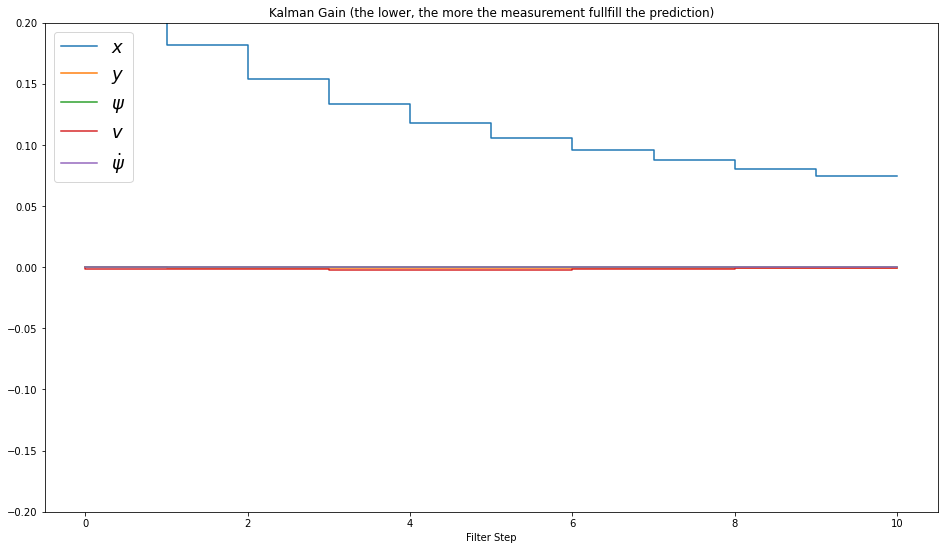

In [5]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),Kx, label='$x$')
plt.step(range(m),Ky, label='$y$')
plt.step(range(m),Kdx, label='$\psi$')
plt.step(range(m),Kdy, label='$v$')
plt.step(range(m),Kddx, label='$\dot \psi$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.2,0.2]);

### Uncertainties

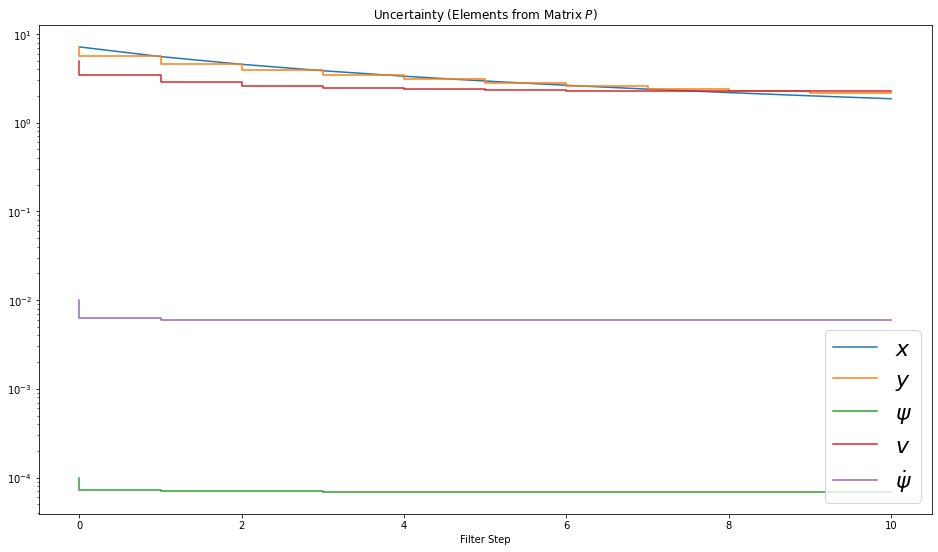

In [6]:

fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### Position x/y

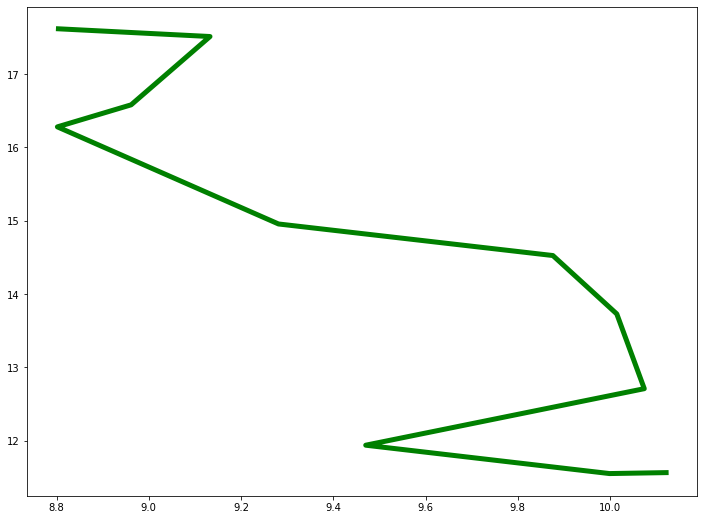

In [7]:
fig = plt.figure(figsize=(12,9))

plt.plot(x0,x1, label='EKF Position', c='g', lw=5)